# Question to the class. Do you think the final model for logistic regression will include the sex of the person as a predictor for survival?

In [2]:
#install.packages('e1071')
library(ggplot2)
library(dplyr)
library(GGally)

library(Amelia)

library(scales) # Visualization
library(caTools) # Prediction: Splitting Data
library(car) # Prediction: Checking Multicollinearity
library(ROCR) # Prediction: ROC Curve
library(e1071) # Prediction: SVM, Naive Bayes, Parameter Tuning
library(rpart) # Prediction: Decision Tree
library(rpart.plot) # Prediction: Decision Tree
library(randomForest) # Prediction: Random Forest
library(caret) # Prediction: k-Fold Cross Validatio

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.5, built: 2018-05-07)
## Copyright (C) 2005-2019 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following 

# This is an example of how your report should look. Don't freak - some of the stuff is more advanced and you don't have to do it in the exact same way*

# The charts are very fancy and there are simpler ways to make charts, like you did in the visualisation ggplot2 tutorial. I just want to show you different types of charts here, also for future reference (I have another notebook which I made in the past where I used less fancy plots - I will also upload it)

# The way I treat missing values is also over exaggerated. But it shows you how you would do it if there were more and you wouldn't want to delete the rows entirely

*for example the function for family size. Noone will judge you if you use EXCEL to do that! e.g. by using "replace" or writing a function in excel. The rule of thumb for programmers is: use the stuff you are more familiar with! I often use Excel if that will take me less time than writing code. That's also a rule in life. Do whatever is more efficient


## Data cleaning and exploration

In [289]:
# loading the data
train = read.csv('train.csv')
test = read.csv('test.csv' )
# Creating a new data set with both the test and the train sets
full = bind_rows(train,test)
str(full)

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning mess

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1           0           0

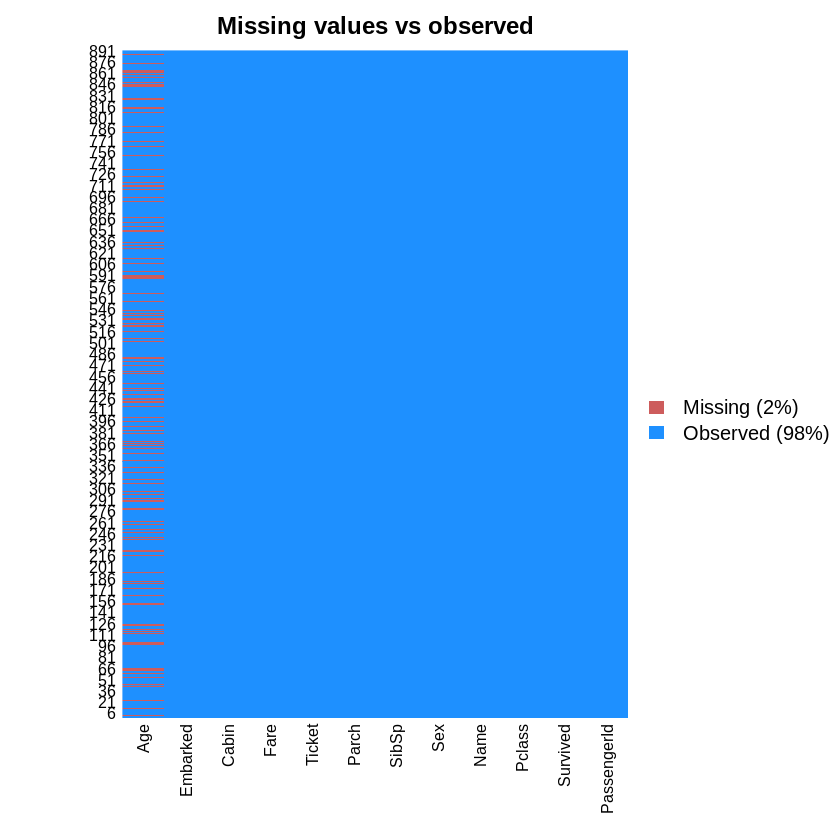

In [290]:
# Missing values
colSums(is.na(full))
missmap(train, main = "Missing values vs observed")

In [291]:
#cabin has a lot of missing values but it's not being picked up as NAN - so let's do it this way
colSums(is.na(full)|full=="")

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1        1014           2

Cabin has the most number of missing values, 1014 values. Age has 263 missing values while Embarked and Fare have two and one missing values, respectively.

# Missing Data Imputation
### The next step is to fill the missing data rows instead of just dropping them.

In [292]:
# this is a crazy example of how to deal with a single missing value but in general this is how you would do it:
# Extract the row which contains the missing Fare
filter(full, is.na(Fare)==TRUE|Fare=='')

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,,S


This male was from the third class and had embarked from Southampton port. Let’s look at the distribution of third class passengers embarked from Southampton port.

Warning message:
“Removed 1 rows containing non-finite values (stat_density).”

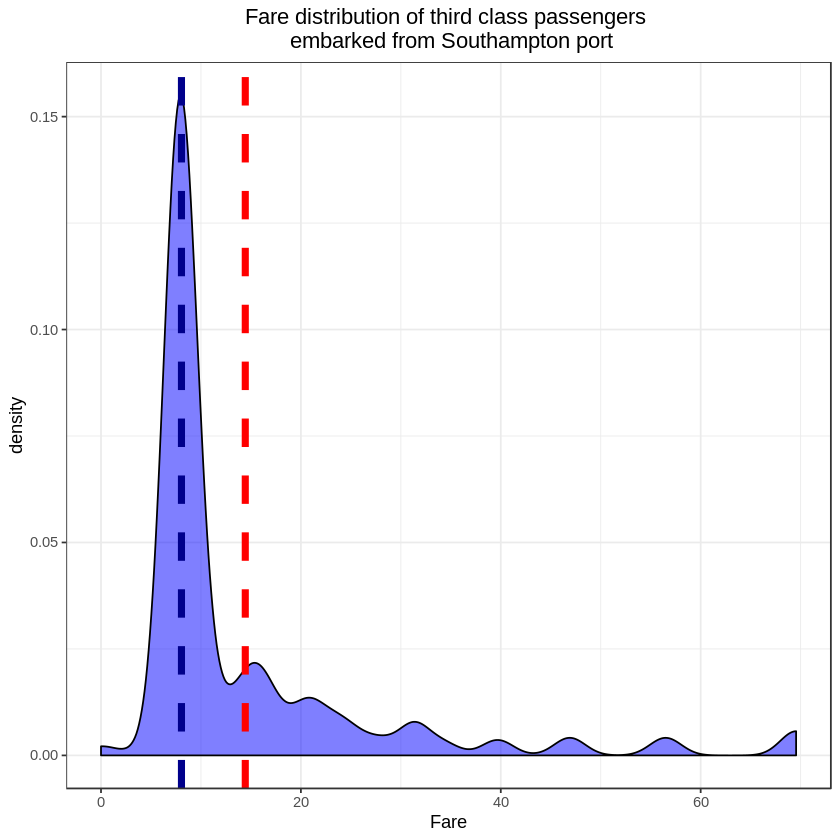

In [293]:
ggplot(filter(full, Pclass==3 & Embarked=="S"), aes(Fare)) +                       
  geom_density(fill="blue", alpha=0.5) +
  geom_vline(aes(xintercept=median(Fare, na.rm=T)), colour='darkblue', linetype='dashed', size=2) +
  geom_vline(aes(xintercept=mean(Fare, na.rm=T)), colour='red', linetype='dashed', size=2) +
  ggtitle("Fare distribution of third class passengers \n embarked from Southampton port") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))

The mean and median fares are not close. The proportion of passengers with fares around median is very high. On the oher hand, it is not that high around mean. So, I believe it is not a good idea to impute the missing fare by the mean of all fares. I would rather impute the missing fare by the median fare of third class passengers embarked from Southampton port.

In [294]:
# Impute the missing Fare value by the median fare of third class passengers embarked from Southampton port
full$Fare[is.na(full$Fare)==TRUE] = median(filter(full, Pclass==3 & Embarked=="S")$Fare, na.rm=TRUE)

# Checking missing values
colSums(is.na(full)|full=='')

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0        1014           2

In [295]:
# now lets deal with embarked
# Extract the rows which contain the missing Embarked values
filter(full, is.na(Embarked)==TRUE|Embarked=='')

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,


Both were females from the first class with $80 fare and had stayed at the same cabin B28. There is a high chance that both embarked from the same port. Let’s look at the frequency of ports of embarkation of first class passengers.

In [296]:
# Frequency of ports of embarkation of first class passengers
table(filter(full, Pclass==1)$Embarked)


      C   Q   S 
  2 141   3 177 

again, this is a crazy example to deal with only 2 missing values but again - thats how you do it
The Southampton port is the most frequent port of embarkation with 177 ports and it is followed by the Cherbourg port with 141. Wait! Yet, we cannot decide to impute two missing values by the most frequent port of embarkation which is the Southampton port.

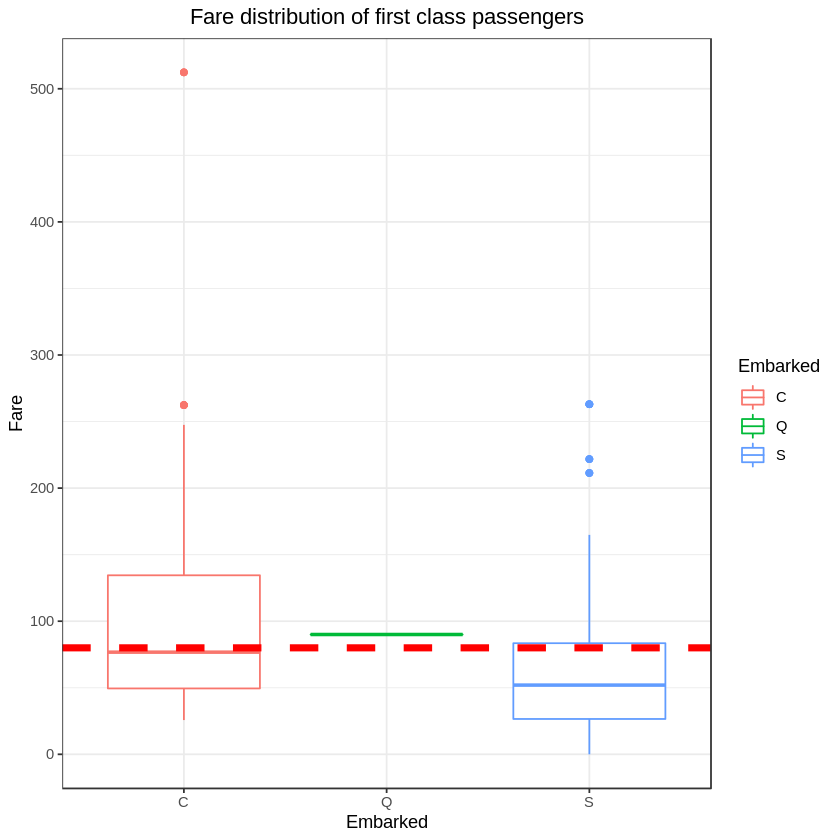

In [297]:
ggplot(filter(full, is.na(Embarked)==FALSE & Embarked!='' & Pclass==1), 
       aes(Embarked, Fare)) +     
  geom_boxplot(aes(colour = Embarked)) +
  geom_hline(aes(yintercept=80), colour='red', linetype='dashed', size=2) +
  ggtitle("Fare distribution of first class passengers") +
  theme_bw() + 
  theme(plot.title = element_text(hjust = 0.5))

The box plot depicts the median fare for Cherbourg port passengers and $80 fare paid by two embarkement-deficient passengers almost concide. Thus, I am going to impute the missing Embarked values by the Cherbourg port.

In [298]:
# Impute the missing Embarked values by the Cherbourg port
full$Embarked[full$Embarked==""] = "C"

# Checking missing values
colSums(is.na(full)|full=='')

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0        1014           0

Warning message:
“Removed 263 rows containing non-finite values (stat_boxplot).”

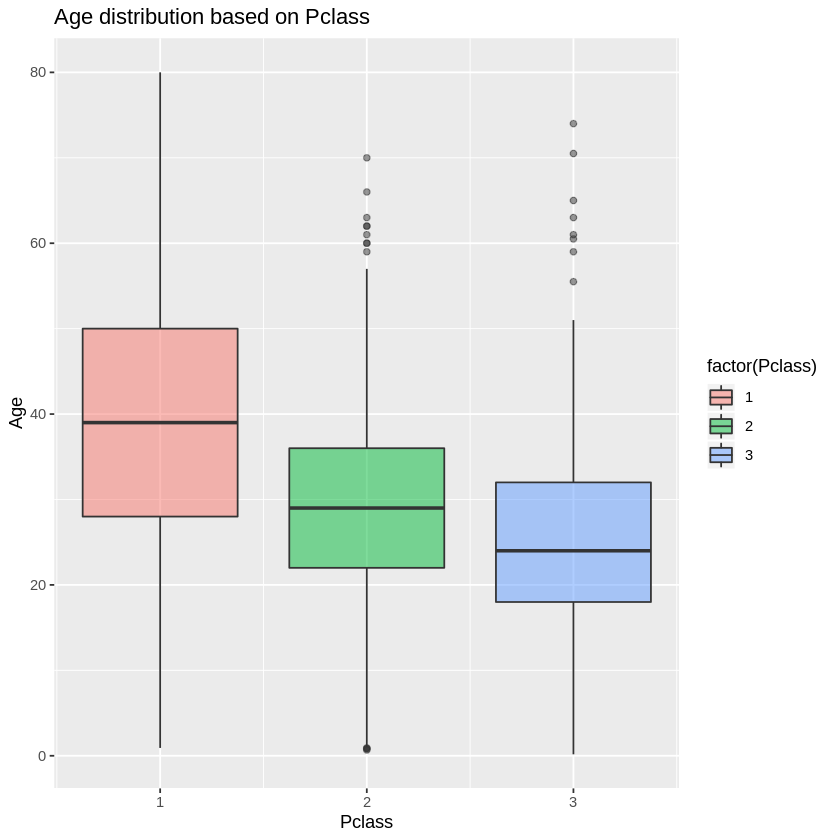

In [299]:
# missing age data manipulation
ggplot(full,aes(Pclass,Age)) +                                                  
  geom_boxplot(aes(fill=factor(Pclass)),alpha=0.5) +
  ggtitle("Age distribution based on Pclass")

It can be clearly seen the median age among classes is not similar (virtually certain, average age among classes is not similar as well). Infact, the passengers in the higher classes tend to be older. Rather than just imputing missing age values by the overall average for age, I will use average age values of each class to impute missing age values based on Pclass.


### another way to deal with age is to take the median age of the corresponding title

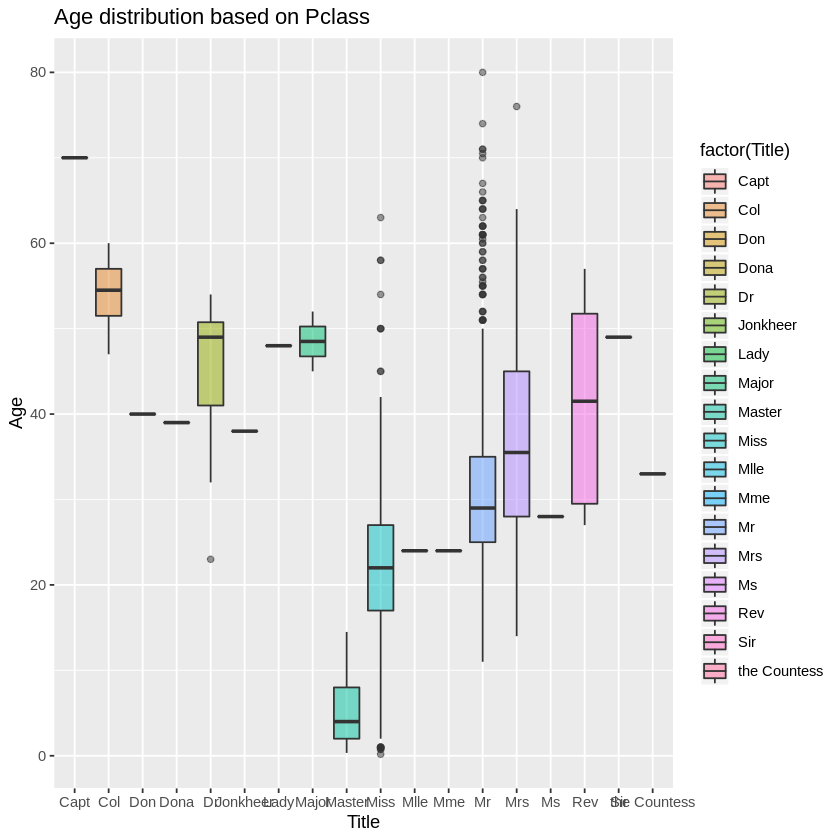

In [305]:
# missing age data manipulation
ggplot(full,aes(Title,Age)) +                                                  
  geom_boxplot(aes(fill=factor(Title)),alpha=0.5) +
  ggtitle("Age distribution based on Pclass")

# this will not work if you copy this as there is no title column yet, its created further down below

# 1 way of dealing with NANs in age: using mean from PClass


In [274]:
# Imputation of Age based on Pclass
impute.age = function(age,class){
  vector = age
  for (i in 1:length(age)){
    if (is.na(age[i])){
      if (class[i] == 1){
        vector[i] = round(mean(filter(full,Pclass==1)$Age, na.rm=TRUE),0)
      }else if (class[i] == 2){
        vector[i] = round(mean(filter(full,Pclass==2)$Age, na.rm=TRUE),0)
      }else{
        vector[i] = round(mean(filter(full,Pclass==3)$Age, na.rm=TRUE),0)
      }
    }else{
      vector[i]<-age[i]
    }
  }
  return(vector)
}
imputed.age <- impute.age(full$Age,full$Pclass)
full$Age <- imputed.age

head(full)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,25,0,0,330877,8.4583,,Q


# Other way: getting title from name and using median amongst title class

In [306]:
# Grab passenger title from passenger name
full$Title <- gsub("^.*, (.*?)\\..*$", "\\1", full$Name)
# Frequency of each title by sex
table(full$Sex, full$Title)
head(full)

        
         Capt Col Don Dona  Dr Jonkheer Lady Major Master Miss Mlle Mme  Mr Mrs
  female    0   0   0    1   1        0    1     0      0  260    2   1   0 197
  male      1   4   1    0   7        1    0     2     61    0    0   0 757   0
        
          Ms Rev Sir the Countess
  female   2   0   0            1
  male     0   8   1            0

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S,Mr
6,0,3,"Moran, Mr. James",male,29,0,0,330877,8.4583,,Q,Mr


In [307]:

missing_row_age = which(is.na(full$Age))
 
for (i in unique(full$Title)) {
  full[missing_row_age, "Age"][full[missing_row_age, "Title"] == i] <- median(subset(full, Title == i)$Age, na.rm = TRUE)
}

In [308]:
# Checking missing values
colSums(is.na(full)|full=='')

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0           0 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0        1014           0 
      Title 
          0

It worked. Now we are left with only Cabin missing values. However, due to the high number of missing values of Cabin feature, I keep the Cabin feature as it is and stop here.

# Feature Engineering

### There are a lot of titanic tutorials out there - most of them engineer some features: for example extracting different titles of the passengers and assign them into categories: Mme, Mrs, Ms all become Mrs. Sir, Master, Don all become Mr etc. There are many different ways to do it, so I just copied some code - feel free to assign the titles otherwise

In [310]:
# Grab passenger title from passenger name
full$Title <- gsub("^.*, (.*?)\\..*$", "\\1", full$Name)
# Frequency of each title by sex
table(full$Sex, full$Title)

        
         Capt Col Don Dona  Dr Jonkheer Lady Major Master Miss Mlle Mme  Mr Mrs
  female    0   0   0    1   1        0    1     0      0  260    2   1   0 197
  male      1   4   1    0   7        1    0     2     61    0    0   0 757   0
        
          Ms Rev Sir the Countess
  female   2   0   0            1
  male     0   8   1            0

In [311]:
# First, I reassign few categories 
full$Title[full$Title == 'Mlle' | full$Title == 'Ms'] <- 'Miss' 
full$Title[full$Title == 'Mme']  <- 'Mrs' 

# Then, I create a new category with low frequency of titles
Other <- c('Dona', 'Dr', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir')
full$Title[full$Title %in% Other]  <- 'Other'

# Let's see if it worked
table(full$Sex, full$Title)


        
         Master Miss  Mr Mrs Other
  female      0  264   0 198     4
  male       61    0 757   0    25

### same with family size. this is subjective. You can create more categories or two (small/big). again, this is just an example on how to group family sizes

In [312]:
#  a new feature on family size can be created using some existing features such as SigSp and Parch.
FamilySize = full$SibSp + full$Parch + 1
table(FamilySize)

FamilySize
  1   2   3   4   5   6   7   8  11 
790 235 159  43  22  25  16   8  11 

In [339]:
# There are nine family sizes: 1 to 8 and 11. As this is too many categories, let’s collapse some categories as follows.
# Create a family size feature with three categories
full$FamilySize <- sapply(1:nrow(full), function(x) 
                          ifelse(FamilySize[x]==1, "Single", 
                          ifelse(FamilySize[x]>4, "Large", "Small")))
table(full$FamilySize)


 Large Single  Small 
    60    790    459 

# EDA - yeay, finally

In [314]:
str(full)

'data.frame':	1309 obs. of  14 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 29 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...
 $ Title      : chr  "Mr" "Mrs" "Miss" "Mrs" ...
 $ FamilySize : chr  "Small" "Small" "Single" "Small" ...


In [340]:
# encoding the categorical features as factors
full$Survived = factor(full$Survived)
full$Pclass = factor(full$Pclass)
full$Embarked = factor(full$Embarked)
full$Title = factor(full$Title)
full$FamilySize = factor(full$FamilySize, levels=c("Single","Small","Large"))

## EDA on Pclass, Sex and Age

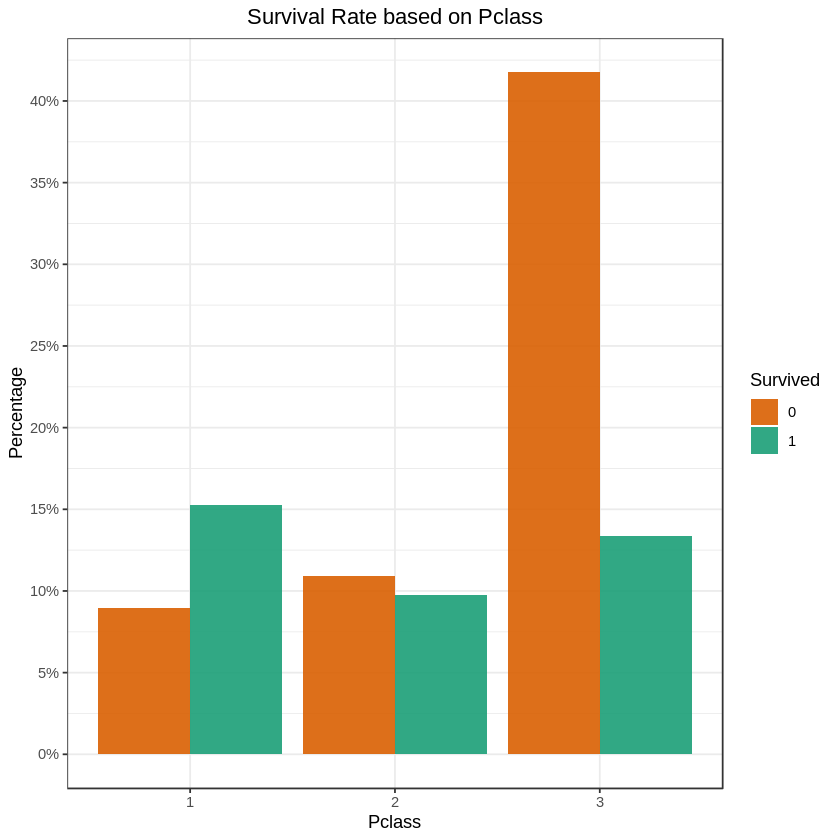

In [341]:
ggplot(filter(full, is.na(Survived)==FALSE), aes(Pclass, fill=Survived)) + 
  geom_bar(aes(y = (..count..)/sum(..count..)), alpha=0.9, position="dodge") +
  scale_fill_brewer(palette = "Dark2", direction = -1) +
  scale_y_continuous(labels=percent, breaks=seq(0,0.6,0.05)) +
  ylab("Percentage") + 
  ggtitle("Survival Rate based on Pclass") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))

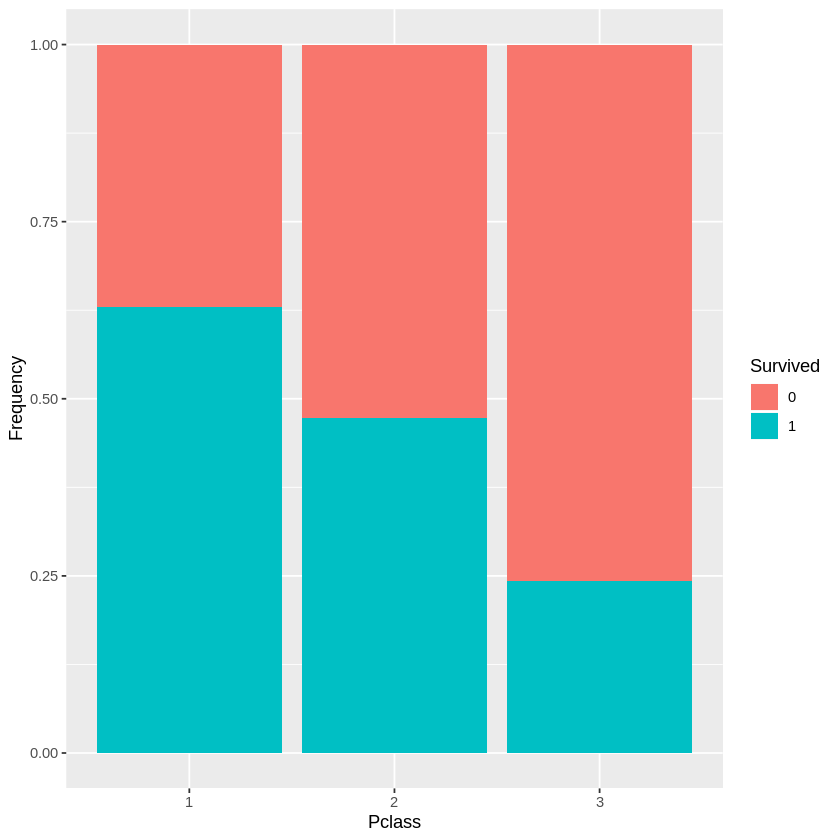

In [246]:
# easier function
LT=dim(train)[1]   #the first half of the data only has survived label, the other half of the data is the test data
# Survival as a function of Pclass:
ggplot(data = full[1:LT,],aes(x=Pclass,fill=Survived))+geom_bar(position="fill")+ylab("Frequency")

It can be seen that females had a higher survival rate than males in each class. This makes sense due to women and children first policy.

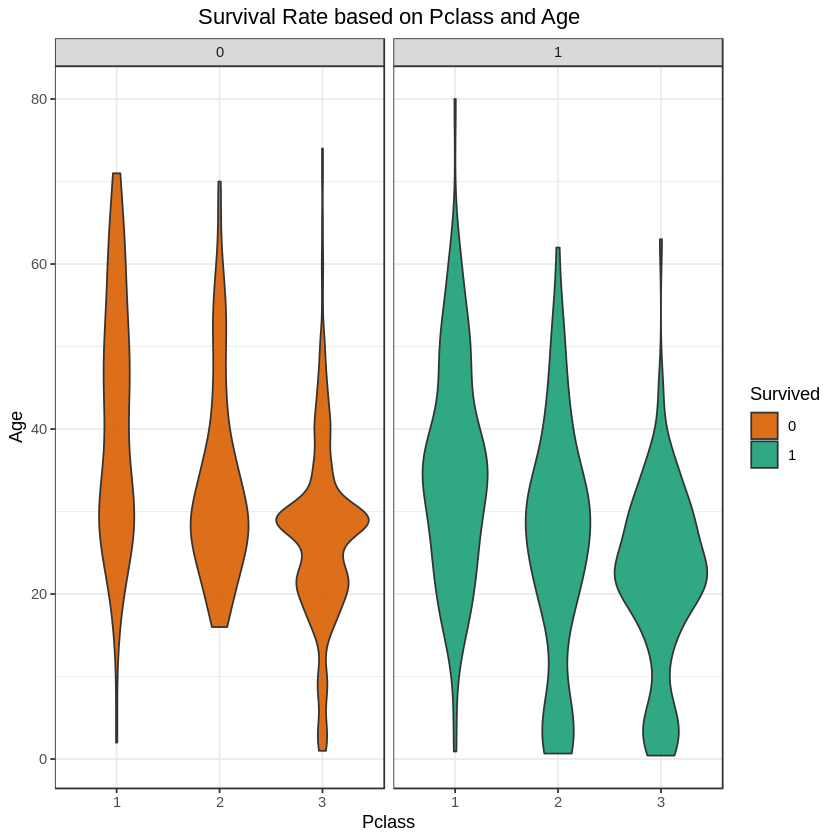

In [342]:
ggplot(filter(full, is.na(Survived)==FALSE), aes(Pclass, Age)) + 
  geom_violin(aes(fill=Survived), alpha=0.9) +
  facet_wrap(~Survived) + 
  scale_fill_brewer(palette = "Dark2", direction = -1) +
  ggtitle("Survival Rate based on Pclass and Age") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))

Overall, the passengers in the higher classes tend to be older disregard to whether they survived or not.

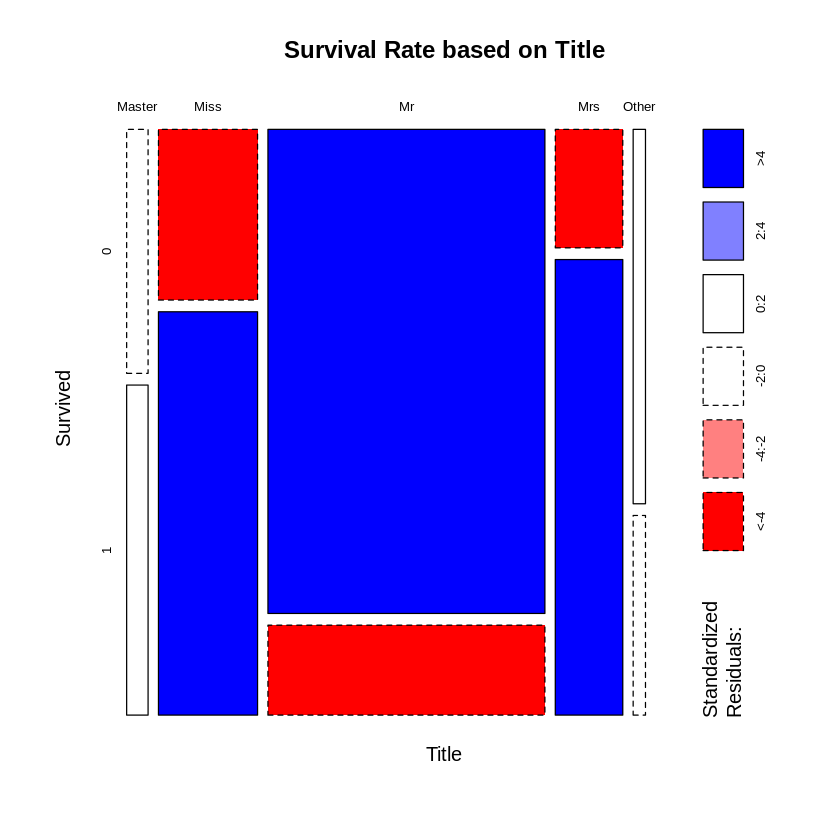

In [343]:
# Exploratory Data Analysis on Title and FamilySize
mosaicplot(~ Title + Survived, data=full, main='Survival Rate based on Title', shade=TRUE)

Generally, male “Mr” passengers had the poorest survival rate.

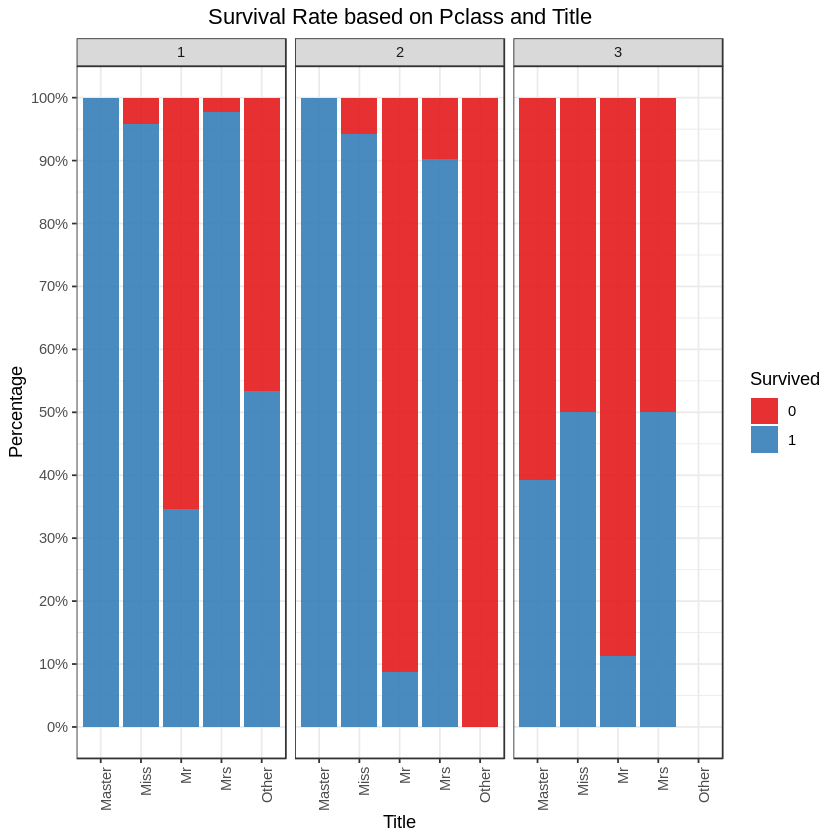

In [344]:
ggplot(filter(full, is.na(Survived)==FALSE), aes(Title)) + 
  geom_bar(aes(fill=Survived), alpha=0.9, position="fill") +
  facet_wrap(~Pclass) + 
  scale_fill_brewer(palette="Set1") +
  scale_y_continuous(labels=percent, breaks=seq(0,1,0.1)) +
  ylab("Percentage") + 
  ggtitle("Survival Rate based on Pclass and Title") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

The same information can be depicted from the above graph - the male “Mr” passengers had the lowest survival rate amongst all the classes.

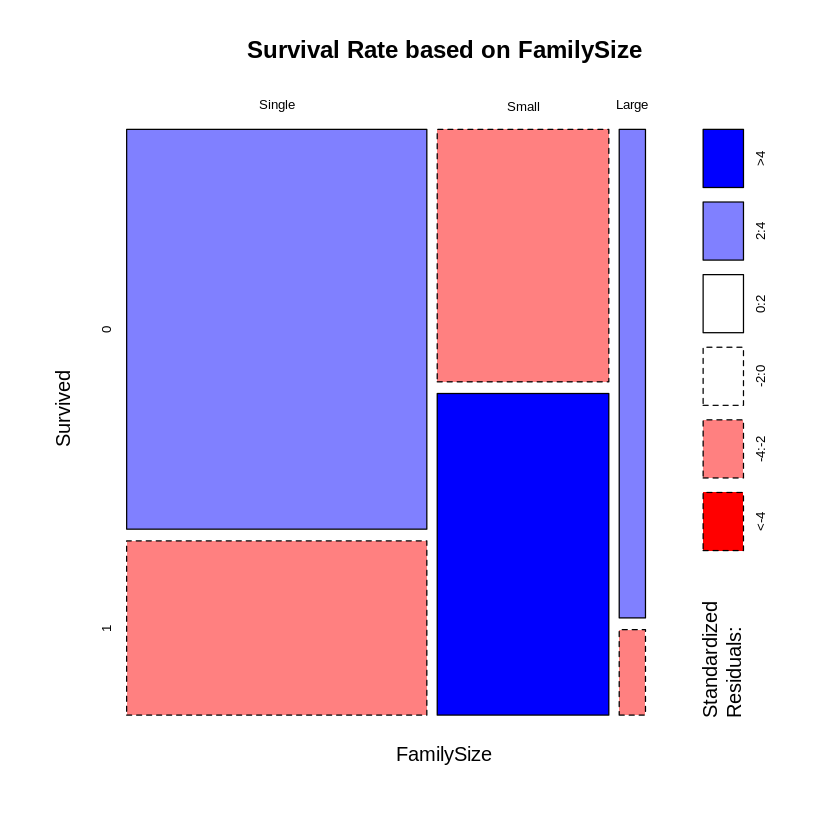

In [345]:


mosaicplot(~ FamilySize + Survived, data=full, main='Survival Rate based on FamilySize', shade=TRUE)

Large families had the worst survival rate than singletons and small families.

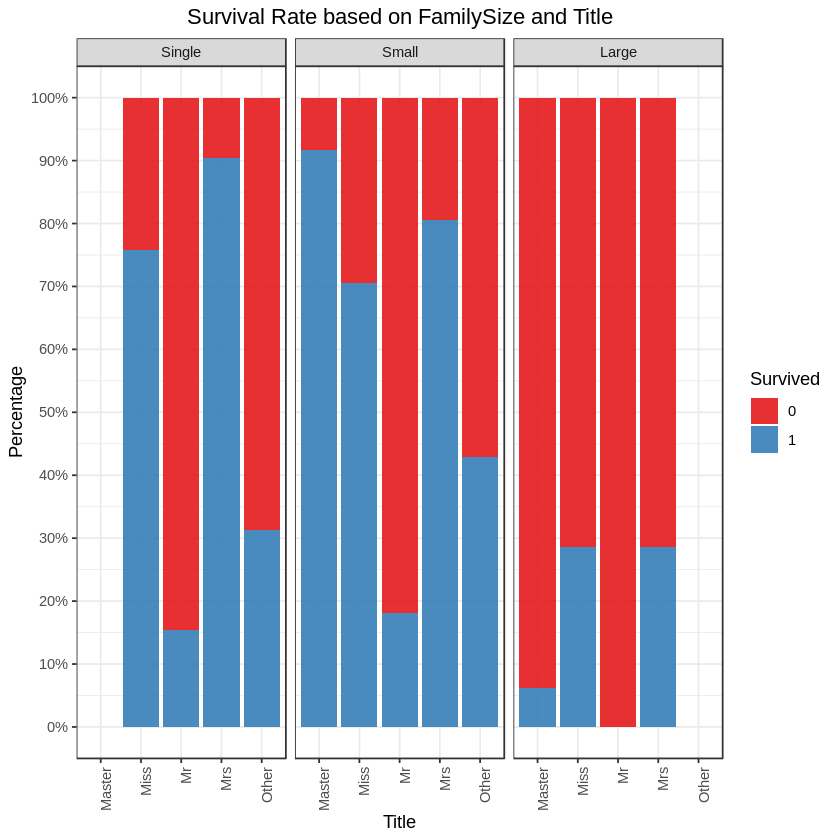

In [346]:
ggplot(filter(full, is.na(Survived)==FALSE), aes(Title)) + 
  geom_bar(aes(fill=Survived), alpha=0.9, position="fill") +
  facet_wrap(~FamilySize) + 
  scale_fill_brewer(palette="Set1") +
  scale_y_continuous(labels=percent, breaks=seq(0,1,0.1)) +
  ylab("Percentage") + 
  ggtitle("Survival Rate based on FamilySize and Title") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

The filled bar chart illustrates that we can preserve our rule: large families had the worst survival rate than singletons and small families. Infact, each member of the large families - Master, Miss, Mr and Mrs - suffered the lowest survival rate than their counterparts in other types of families.

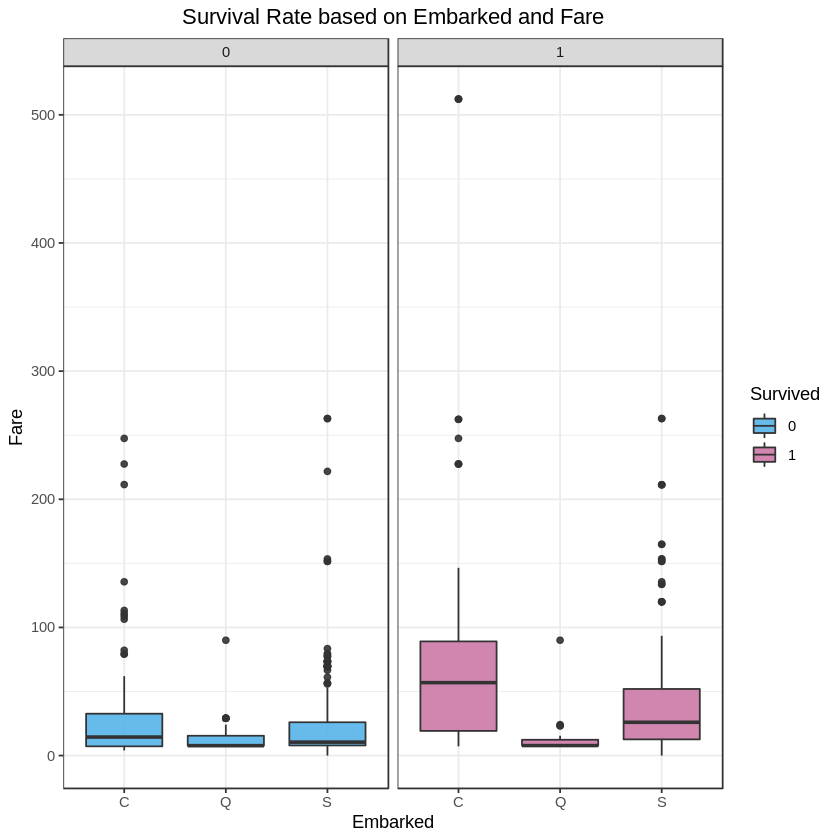

In [347]:
#  Exploratory Data Analysis on Fare and Embarked
ggplot(filter(full, is.na(Survived)==FALSE), aes(Embarked, Fare)) + 
  geom_boxplot(aes(fill=Survived), alpha=0.9) +
  facet_wrap(~Survived) + 
  scale_fill_manual(values=c("#56B4E9", "#CC79A7")) +
  ggtitle("Survival Rate based on Embarked and Fare") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))

Interestingly, there is a substantial variation of fares in the survived category, especially from Cherbourg and Southampton ports.

Visual analysis of data concludes:

    - the wealthier passengers in the first class had a higher survival rate;

    - females had a higher survival rate than males in each class;

    - male “Mr” passengers had the lowest survival rate amongst all the classes; and

    - large families had the worst survival rate than singletons and small families.

Woo-ah! After rectifying the missing values and exploring data visually, finally, we are ready to predict whether or not each passenger in the test set survived the sinking of the Titanic. I identify the following features may contribute to the prediction of the survival and include them in the classification algorithms: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, Title and FamilySize.

    - I ignore the feature Name as I have created a new feature Title from it and I believe the title has more predictive power than just name.

    - I ignore the feature Ticket as I believe it does not preserve any predictive power on survival.

    - I ignore the feature Cabin since it has many missing values.


#  Model Building

## Today we will use Logistic Regression and Naive Bayes. We will continue with this dataset tomorrow and use KNN and Decision Trees and Random Forest next week and compare them all! Exciting

### Splitting the dataset into the Training set and Test set

After rectifying the missing values and encoding the categorical features as factors, now we are good to split the dataset into the training and test sets.

In [348]:
train_original = full[1:891, c("Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Title","FamilySize")]
test_original = full[892:1309, c("Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Title","FamilySize")]



Now I split the training set into the training set (80% of training data) and validation set (20% of training data) for the evaluation purposes of the fitted models. Validation is the test set for our training set. Don't get confused by the terminology. It's the same what we did the last few days

In [349]:
# Splitting the Training set into the Training set and Validation set
set.seed(789)
split = sample.split(train_original$Survived, SplitRatio = 0.8)
train = subset(train_original, split == TRUE)
test = subset(train_original, split == FALSE)


#cross validation

set.seed(123)
train.control = trainControl(method = "repeatedcv", number =100, repeats=3)
model_reg = train(Survived ~ .,  data=train, method="glm", family="binomial", trControl = train.control)
summary(model_reg)
print(model_reg)

#


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4021  -0.5908  -0.3692   0.5633   2.4854  

Coefficients:
                  Estimate Std. Error z value        Pr(>|z|)    
(Intercept)      18.814398 507.493552   0.037         0.97043    
Pclass2          -1.117856   0.353203  -3.165         0.00155 ** 
Pclass3          -2.348574   0.358554  -6.550 0.0000000000575 ***
Sexmale         -14.727009 507.493091  -0.029         0.97685    
Age              -0.024406   0.010430  -2.340         0.01928 *  
SibSp            -0.441607   0.221963  -1.990         0.04664 *  
Parch            -0.103139   0.214849  -0.480         0.63119    
Fare              0.001556   0.002944   0.528         0.59719    
EmbarkedQ         0.066196   0.421644   0.157         0.87525    
EmbarkedS        -0.376829   0.279041  -1.350         0.17687    
TitleMiss       -15.239073 507.493426  -0.030         0.97604    
TitleMr          -3.318282   0.625882  -5.302 0.0000001146860 ***
T

Generalized Linear Model 

713 samples
  9 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (100 fold, repeated 3 times) 
Summary of sample sizes: 707, 706, 706, 706, 706, 706, ... 
Resampling results:

  Accuracy   Kappa    
  0.8106151  0.5929934



Be aware that accuracy will be the same whether you use CV or not. It is because no parameters are being manipulted … the cv for glm only gives you an estimate of your test set error rate / accuracy , and cannot improve over the output of logit..

### Ok so the above summary already gives us some interesting insights. Standard errors are very high for sexmale, title miss and mrs. This has to do with multicollinearity. Logistic regression assumes that the variables are independent. this is of courese not the case for sex and title. Just by thinking about it, you can make this connenction and not inclide one of these variables in your model. This will be enough for me in your report and in the exam. But let's do it properly. Don't worry if you dont follow - this is for future reference and you can do some extra reading in your own time.

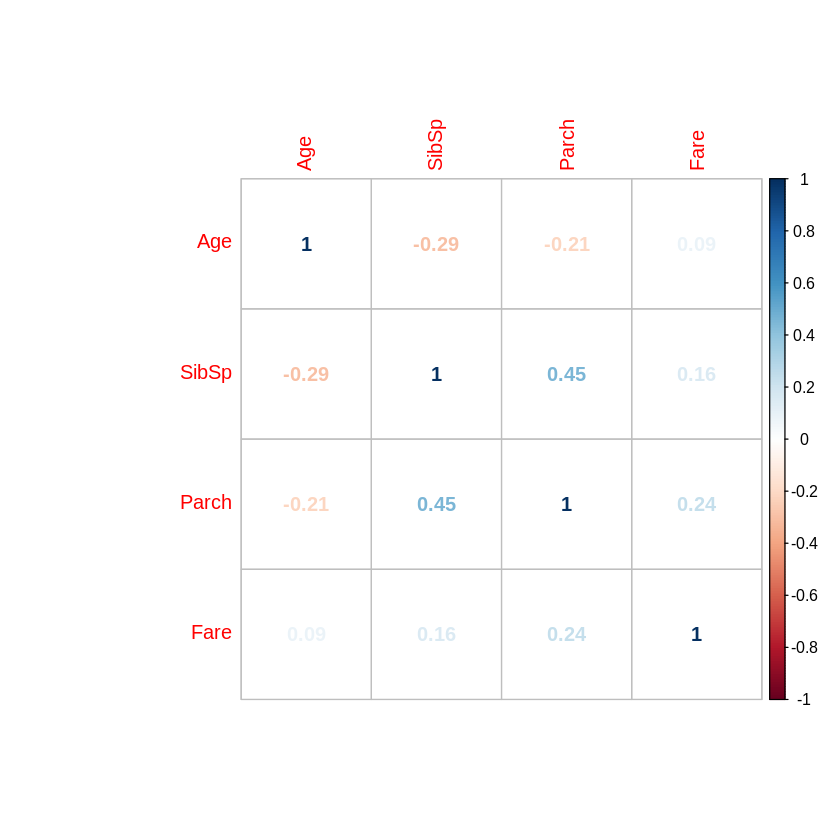

In [350]:
# checking correlation of numeric variables
train_num = select_if(train, is.numeric)
#correlation matric
library(corrplot)
corrplot(cor(train_num), method="number")

its not surprising that number of siblings/spouses and number of parents/children are correlated, but it's not super high and didnt cause any problems in the model above, so we will leave it as it is

## now...how to deal with categorical variables? in statistics you use Chi-Square for that

In [351]:

train_cat = select_if(train, is.factor)
head(train_cat)

Survived,Pclass,Sex,Embarked,Title,FamilySize
0,3,male,S,Mr,Small
1,1,female,C,Mrs,Small
1,3,female,S,Miss,Single
1,1,female,S,Mrs,Small
0,3,male,S,Mr,Single
0,3,male,Q,Mr,Single


In [352]:
train_cat = train_cat[,-1]
head(train_cat)   #deleting survived

Pclass,Sex,Embarked,Title,FamilySize
3,male,S,Mr,Small
1,female,C,Mrs,Small
3,female,S,Miss,Single
1,female,S,Mrs,Small
3,male,S,Mr,Single
3,male,Q,Mr,Single


In [353]:
chisqmatrix <- function(x) {
  names = colnames(x);  num = length(names)
  m = matrix(nrow=num,ncol=num,dimnames=list(names,names))
  for (i in 1:(num-1)) {
    for (j in (i+1):num) {
      m[i,j] = chisq.test(x[,i],x[,j],)$p.value
    }
  }
  return (m)
}
mat = chisqmatrix(train_cat)

Warning message in chisq.test(x[, i], x[, j], ):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x[, i], x[, j], ):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x[, i], x[, j], ):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x[, i], x[, j], ):
“Chi-squared approximation may be incorrect”

In [354]:
#options(scipen=999)
mat

,Pclass,Sex,Embarked,Title,FamilySize
Pclass,NA,0.002532566,0.000000000000000000000010531,0.000000000596230119749838284794869127812457637594079074006003793329000473022460937500000000000000000000000000000000000000000000000000000000000000000000000000,0.000000005132230128061835721276114086197850383541663177311
Sex,NA,NA,0.013215931368111050528413308,0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001116723,0.000000000000000492202431975110242155921211150682452598588
Embarked,NA,NA,NA,0.000138316877840488351410555556419978984195040538907051086425781250000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,0.000002910867123854506541882338974125410402393754338845611
Title,NA,NA,NA,NA,0.000000000000000000000000000000000000000000000000001346328
FamilySize,NA,NA,NA,NA,NA


bad...all these variables are highly correlated. Since all the p-values < 0.05, we reject each Ho:Two factors are independent at 5% significance level and indeed at any reasonable level of significance. This violates the independence assumption of features and can be confirmed that multicollinearity does exist among factors

In [355]:
# I will use glm() function because it's easier to use for the stuff I want
classifier_logreg = glm(Survived ~ ., family = binomial(link='logit'), data = train)

# Choosing the best model by AIC in a Stepwise Algorithm
# The step() function iteratively removes insignificant predictor variables from the model.
classifier_logreg = step(classifier_logreg)

Start:  AIC=621.31
Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + 
    Title + FamilySize

             Df Deviance    AIC
- FamilySize  2   591.48 619.48
- Parch       1   589.54 619.54
- Fare        1   589.60 619.60
- Embarked    2   592.21 620.21
<none>            589.31 621.31
- Sex         1   593.24 623.24
- SibSp       1   593.55 623.55
- Age         1   594.97 624.97
- Title       4   626.85 650.85
- Pclass      2   636.43 664.43

Step:  AIC=619.48
Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + 
    Title

           Df Deviance    AIC
- Fare      1   591.82 617.82
- Embarked  2   594.66 618.66
- Parch     1   592.93 618.93
<none>          591.48 619.48
- Sex       1   595.41 621.41
- Age       1   597.83 623.83
- SibSp     1   609.99 635.99
- Title     4   631.69 651.69
- Pclass    2   640.78 664.78

Step:  AIC=617.82
Survived ~ Pclass + Sex + Age + SibSp + Parch + Embarked + Title

           Df Deviance    AIC
- Parch     1   593.03 617

## ok so the best model apparently is: Survived ~ Pclass + Sex + Age + Title + FamilySize

In [356]:
summary(classifier_logreg)


Call:
glm(formula = Survived ~ Pclass + Sex + Age + SibSp + Title, 
    family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4661  -0.6262  -0.3767   0.5695   2.7330  

Coefficients:
             Estimate Std. Error z value             Pr(>|z|)    
(Intercept)  18.53693  502.23857   0.037              0.97056    
Pclass2      -1.32487    0.31020  -4.271         0.0000194529 ***
Pclass3      -2.52036    0.29211  -8.628 < 0.0000000000000002 ***
Sexmale     -14.61391  502.23822  -0.029              0.97679    
Age          -0.02596    0.01022  -2.540              0.01109 *  
SibSp        -0.58924    0.12794  -4.605         0.0000041156 ***
TitleMiss   -14.90383  502.23851  -0.030              0.97633    
TitleMr      -3.18185    0.58688  -5.422         0.0000000591 ***
TitleMrs    -14.39268  502.23860  -0.029              0.97714    
TitleOther   -2.59816    0.84888  -3.061              0.00221 ** 
---
Signif. codes:  0 ‘

### appart from the high st errors that we already identified above - why is sex not statistically significant although it was selected in the best model?

### lets look at the variance inflation factor -  a way to measure the effect of multicollinearity among your predictor (look it up in your own time)

In [357]:
vif(classifier_logreg)

,GVIF,Df,GVIF^(1/(2*Df))
Pclass,1.479402,2,1.102863
Sex,5856064.130345,1,2419.930604
Age,1.899633,1,1.378272
SibSp,1.523855,1,1.234445
Title,12355035.377008,4,7.699819


### this statistically confirms what we already logically inferred above - the multicollinearity between factors Sex and Title. So how do we deal with this? We exclude one of the factors

In [358]:
#lets see which one performs better
classifier_lr_nosex = glm(Survived ~ . -Sex, family = binomial(link='logit'), data = train)

classifier_lr_notitle = glm(Survived ~ . -Title, family = binomial(link='logit'), data = train)

In [359]:
classifier_lr_nosex = step(classifier_lr_nosex)


Start:  AIC=623.24
Survived ~ (Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + 
    Title + FamilySize) - Sex

             Df Deviance    AIC
- FamilySize  2   595.41 621.41
- Fare        1   593.49 621.49
- Parch       1   593.50 621.50
- Embarked    2   595.85 621.85
<none>            593.24 623.24
- SibSp       1   597.71 625.71
- Age         1   599.11 627.11
- Pclass      2   641.07 667.07
- Title       4   775.48 797.48

Step:  AIC=621.41
Survived ~ Pclass + Age + SibSp + Parch + Fare + Embarked + Title

           Df Deviance    AIC
- Fare      1   595.71 619.71
- Embarked  2   598.36 620.36
- Parch     1   596.86 620.86
<none>          595.41 621.41
- Age       1   601.98 625.98
- SibSp     1   614.20 638.20
- Pclass    2   645.44 667.44
- Title     4   797.60 815.60

Step:  AIC=619.71
Survived ~ Pclass + Age + SibSp + Parch + Embarked + Title

           Df Deviance    AIC
- Parch     1   596.94 618.94
- Embarked  2   598.99 618.99
<none>          595.71 619.71
- Age  

In [360]:
classifier_lr_notitle = step(classifier_lr_notitle)

Start:  AIC=650.85
Survived ~ (Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + 
    Title + FamilySize) - Title

             Df Deviance    AIC
- Fare        1   626.85 648.85
- Parch       1   626.91 648.91
- Embarked    2   630.12 650.12
<none>            626.85 650.85
- SibSp       1   629.36 651.36
- FamilySize  2   631.69 651.69
- Age         1   647.53 669.53
- Pclass      2   685.69 705.69
- Sex         1   775.48 797.48

Step:  AIC=648.85
Survived ~ Pclass + Sex + Age + SibSp + Parch + Embarked + FamilySize

             Df Deviance    AIC
- Parch       1   626.91 646.91
- Embarked    2   630.16 648.16
<none>            626.85 648.85
- SibSp       1   629.36 649.36
- FamilySize  2   631.70 649.70
- Age         1   647.61 667.61
- Pclass      2   709.34 727.34
- Sex         1   776.22 796.22

Step:  AIC=646.91
Survived ~ Pclass + Sex + Age + SibSp + Embarked + FamilySize

             Df Deviance    AIC
- Embarked    2   630.16 646.16
<none>            626.91 646.91
- Fa

#  best models

## no sex model: Survived ~ Pclass + Age + Title + FamilySize

## no title model: Survived ~ Pclass + Sex + Age + Parch + FamilySize


### but we see from the AIC score that the nosex classifier is better


In [361]:
anova(classifier_lf_nosex, classifier_logreg, test ="Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
698,584.3690,NA,NA,NA
703,596.6273,-5,-12.25833,0.03141446


In [330]:
anova(classifier_lf_nosex, classifier_lf_notitle, test ="Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
698,584.3690,NA,NA,NA
701,616.1411,-3,-31.77215,0.0000005845269


### ok so we see that the nosex classifier is significantly better than the notitle classifier 
### however, the difference between the classifier that uses all the predictors and the nosex one is borderline

### HOWEVER - the whole model has 9 predictors and the nosex model has 4. 5 predictors don't add any value to it and sex is one of them - isnt' that interesting? Who would have thought that sex is not a valuable predictor

# Prediction (finally!)

### According to the best model, the features Pclass, Age, Title and FamilySize significantly contribute to the model in predicting survival. We will see how well the model predicts on new data in the validation set.

In [362]:
#lets rename our classifier
best_LR_classifier = classifier_lr_nosex

# Predicting the Validation set results
prob_pred_best = predict(best_LR_classifier, type = 'response', newdata = test)
y_pred = ifelse(prob_pred_best > 0.5, 1, 0)


# Checking the prediction accuracy
table(test$Survived, y_pred > 0.5) # Confusion matrix


   
    FALSE TRUE
  0    98   12
  1    17   51

In [363]:
error <- mean(test$Survived != y_pred) # Misclassification error
paste('Accuracy',round(1-error,10))

[1] "Accuracy 0.8370786517"

In [364]:
#lets test with the others for fun

# Predicting the Validation set results
prob_pred_2 = predict(classifier_lf_notitle, type = 'response', newdata = test)
y_pred = ifelse(prob_pred_2 > 0.5, 1, 0)


# Checking the prediction accuracy
table(test$Survived, y_pred > 0.5) # Confusion matrix

error <- mean(test$Survived != y_pred) # Misclassification error
paste('Accuracy',round(1-error,10))

   
    FALSE TRUE
  0   102    8
  1    20   48

[1] "Accuracy 0.8426966292"

In [365]:
#lets test with the others for fun

# Predicting the Validation set results
prob_pred_3 = predict(classifier_logreg, type = 'response', newdata = test)
y_pred = ifelse(prob_pred_3 > 0.5, 1, 0)


# Checking the prediction accuracy
table(test$Survived, y_pred > 0.5) # Confusion matrix

error <- mean(test$Survived != y_pred) # Misclassification error
paste('Accuracy',round(1-error,10))

   
    FALSE TRUE
  0   100   10
  1    18   50

[1] "Accuracy 0.8426966292"

# ROC Curve
The ROC curve is created by plotting the true positive rate against the false positive rate at various threshold settings.

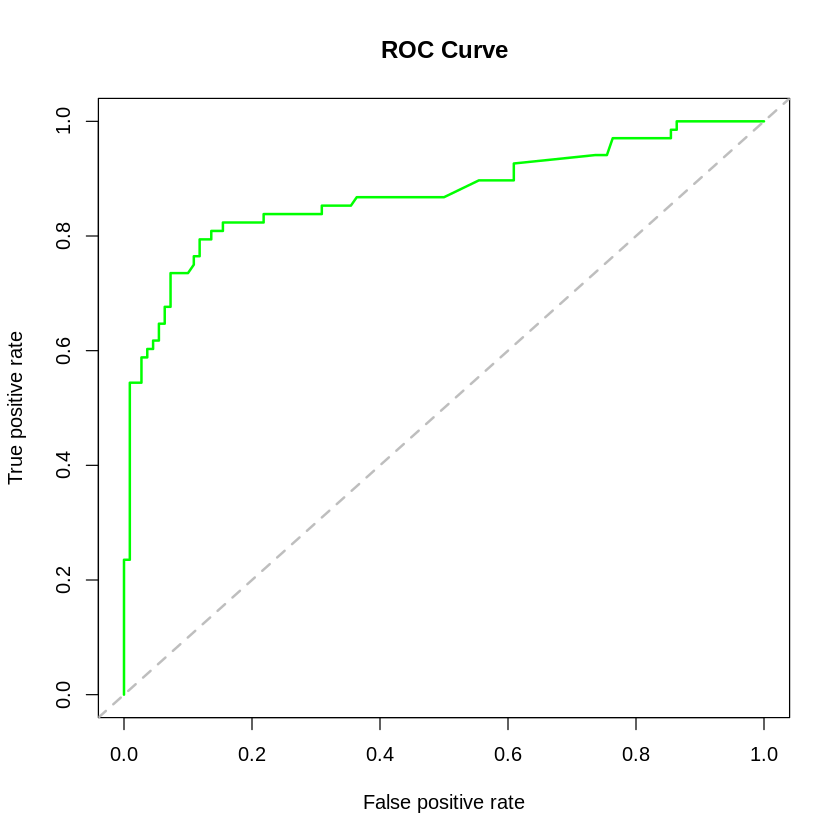

In [366]:
# Use the predictions to build a ROC curve to assess the performance of our model
fitpred = prediction(prob_pred_best, test$Survived)
fitperf = performance(fitpred,"tpr","fpr")
plot(fitperf,col="green",lwd=2,main="ROC Curve")
abline(a=0,b=1,lwd=2,lty=2,col="gray")

The ROC (Receiver Operating Characteristics) curve is a graphical representation of the performnace of the classifier and it shows the performance of our model rises well above the diagonal line. This indicates that our logistic regression model performs better than just a random guess. The logistic regression model delivers a whooping 0.865 accuracy interms of predicting the survival.

### we see that on our validation set they all preform the same (whole model 1% better) - we need to predict on the actual test set and submit to kaggle to check which one performs the best in real life

In [336]:
#lets test with the others for fun

# Predicting the Validation set results
prob_pred = predict(classifier_logreg, type = 'response', newdata = test_original)
test_original$y_pred_all = ifelse(prob_pred > 0.5, 1, 0)



In [337]:
write.csv(test_original, file = "predicted_titanic.csv")

In [367]:
#lets train with whole data now
classifier_lr_kaggle = glm(Survived ~ Pclass + Age + Title + FamilySize, family = binomial(link='logit'), data = train_original)
prob_pred = predict(classifier_lr_kaggle, type = 'response', newdata = test_original)
test_original$LR_predicted = ifelse(prob_pred > 0.5, 1, 0)

write.csv(test_original, file = "predicted_titanic.csv")

# Kaggle scores:
### ALL: 0.77990
### Notitle: 0.76555
### Best (nosex): 0.77990 
### Best trained on whole data: 0.78468

Best and All give the highest scores - but not by much (1%)

# Now let's use Naive Bayes
Naive Bayes is based on the assumption that conditional probability of each feature given the class is independent of all the other features. The assumption of independent conditional probabilities means the features are completely independent of each other. We already disproved this assumption above and we have found that numeric features are independent to each other, however, the categorical features are not. By assuming the idependence assumption of all the features, let’s fit a naive bayes model to our training data.

In [215]:
# Fitting Naive Bayes to the Training set
classifier = naiveBayes(Survived ~ ., data = train)

# Predicting the Validation set results
y_pred = predict(classifier, newdata = test) #test[,-which(names(test)=="Survived")])

# Checking the prediction accuracy
table(test$Survived, y_pred) # Confusion matrix

   y_pred
     0  1
  0 99 11
  1 17 51

In [216]:
error <- mean(test$Survived != y_pred) # Misclassification error
paste('Accuracy',round(1-error,4))

[1] "Accuracy 0.8427"

### You can also use caret train() function with cross validation - accuracy goes down. But it's still pretty decent given how simple NB is

In [217]:
#install.packages('klaR')
set.seed(123)
train.control = trainControl(method = "repeatedcv", number =10, repeats=3)
model_nb = train(Survived ~ .,  data=train, method="nb", trControl = train.control)


# Predicting the Validation set results
y_pred = predict(model_nb, newdata = test ) #[,-which(names(test)=="Survived")])

# Checking the prediction accuracy
table(test$Survived, y_pred) # Confusion matrix

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 30”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 41”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 53”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 58”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 69”Warning message in FU

“Numerical 0 probability for all classes with observation 47”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 51”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 64”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 66”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 70”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability 

“Numerical 0 probability for all classes with observation 23”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 36”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 43”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 50”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 54”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 58”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 66”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 69”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”Warning message in FUN(X[[i]], ...):
“Numerical 0 probabili

“Numerical 0 probability for all classes with observation 16”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 33”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 38”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 44”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 46”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 52”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 53”Warning message in FUN(X[[i]], ...):
“Numerical 0 probabi

“Numerical 0 probability for all classes with observation 51”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 56”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 58”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 64”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 66”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 40”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 43”Warning message in FUN(X[[i]], ...):
“Numerical 0 probabilit

   y_pred
     0  1
  0 95 15
  1 19 49

In [218]:
error <- mean(test$Survived != y_pred) # Misclassification error
paste('Accuracy',round(1-error,4))

[1] "Accuracy 0.809"

In [160]:
# Predicting the Validation set results
test_original$y_NB = predict(model_nb, newdata = test_original)


Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 54”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 56”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 60”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 64”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 65”Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 67”Warning message in FUN

In [162]:
write.csv(test_original, file = "predicted_titanic.csv")

# Kaggle score Naive Bayes (all predictors): 0.76076 
# Kaggle score NB ("best" predictors): 0.76555

Naive bayes performs very similar to LG (very slightly worse)

In [219]:
# lets also train one using the best predictors
classifier_NB_best = naiveBayes(Survived ~ Pclass + Age + Title + FamilySize, data = train)
# Predicting the Validation set results
y_pred = predict(classifier_NB_best, newdata = test[,-which(names(test)=="Survived")])

# Checking the prediction accuracy
table(test$Survived, y_pred) # Confusion matrix

   y_pred
     0  1
  0 94 16
  1 20 48

In [184]:
test_original$y_NB_best = predict(classifier_NB_best, newdata = test_original)
write.csv(test_original, file = "predicted_titanic.csv")

# And the last classifier for this week: K-NN!

### Finding best number of clusters with the elbow method

The elbow method compares the amount of variance against the number of clusters. Not enough clusters lead to too much variance, while too many clusters lead to overfitting. The approach is to choose the number of clusters that participates to the biggest variance reduction. This is the elbow of the chart below.

In [220]:
model_knn <- train(Survived~., data=train, method="knn", tuneGrid = expand.grid(k = 1:20),
    trControl=train.control)

In [221]:
summary(model_knn)
print(model_knn)

            Length Class      Mode     
learn        2     -none-     list     
k            1     -none-     numeric  
theDots      0     -none-     list     
xNames      15     -none-     character
problemType  1     -none-     character
tuneValue    1     data.frame list     
obsLevels    2     -none-     character
param        0     -none-     list     

k-Nearest Neighbors 

713 samples
  9 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 642, 641, 642, 641, 643, 641, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.7134606  0.3902899
   2  0.7091883  0.3850045
   3  0.7209583  0.4069067
   4  0.7003460  0.3611274
   5  0.7107080  0.3822829
   6  0.6933756  0.3430178
   7  0.7064496  0.3694211
   8  0.7007691  0.3547113
   9  0.7092205  0.3705372
  10  0.7101205  0.3724739
  11  0.7171367  0.3853709
  12  0.7119981  0.3756699
  13  0.7175997  0.3832735
  14  0.7138298  0.3721727
  15  0.7138298  0.3708164
  16  0.7082486  0.3540899
  17  0.7036061  0.3408473
  18  0.6993999  0.3296120
  19  0.6947379  0.3141695
  20  0.6942818  0.3134535

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 3.


In [222]:
y_pred = predict(model_knn, newdata = test)

# Checking the prediction accuracy
table(test$Survived, y_pred) # Confusion matrix

   y_pred
     0  1
  0 93 17
  1 27 41

In [223]:
error <- mean(test$Survived != y_pred) # Misclassification error
paste('Accuracy',round(1-error,4))

[1] "Accuracy 0.7528"

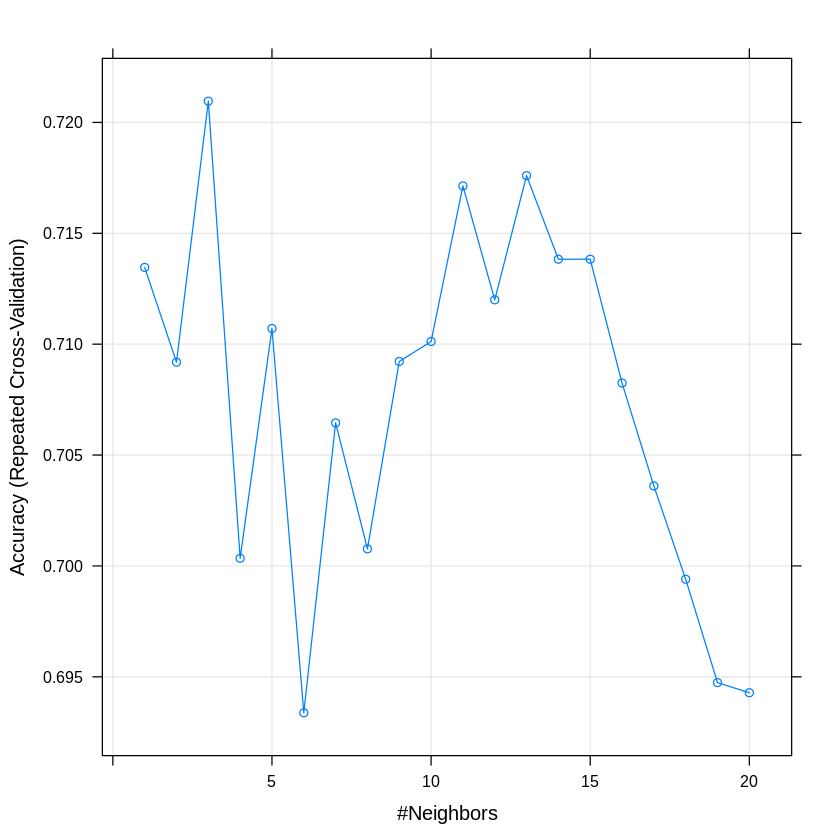

In [224]:
plot(model_knn)

In [181]:
test_original$y_KNN = predict(model_knn, newdata = test_original)
write.csv(test_original, file = "predicted_titanic.csv")

# Kaggle score: 0.61722 (worst so far) - lets see whether we can improve this next week with decision trees and random forrest

It doesn't really make sense to use KNN for this task since KNN is a distance based technique and is used to assign tatapoints to clusters - the more separable the clusters are the better (e.g. different types of flowers). Here survived and not survived are not two clearly separate clusters based on certain factors, so KNN performs the worst. 

# Decision Tree

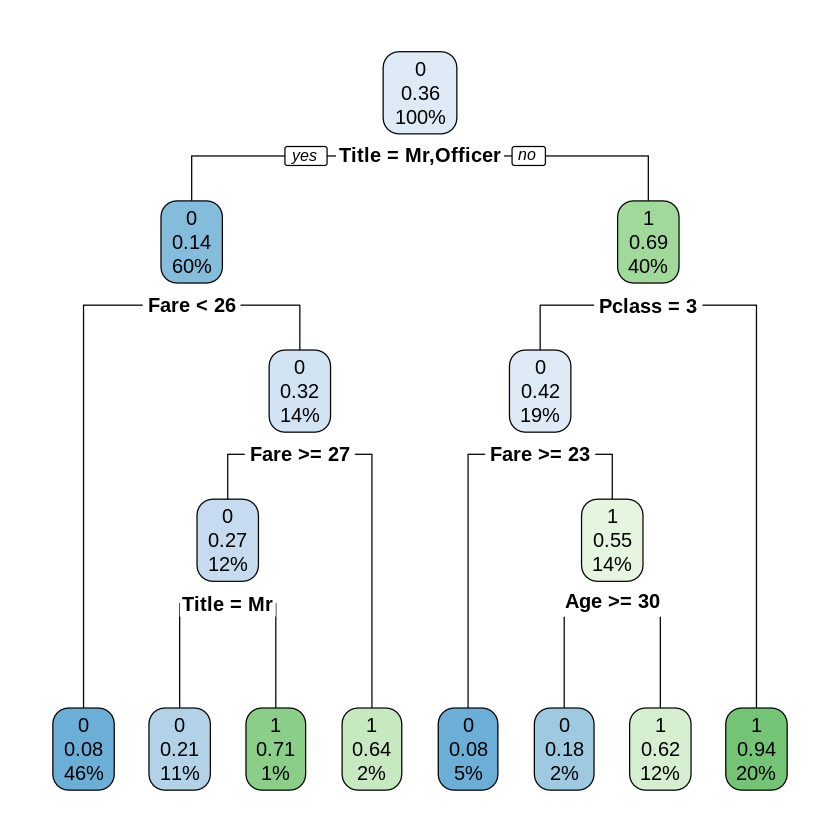

In [190]:
model_dt<- rpart(Survived ~.,data=train1, method="class")
rpart.plot(model_dt)

In [196]:
pred.train.dt <- predict(model_dt,train2,type = "class")
mean(pred.train.dt==train2$Survived)
t2<-table(pred.train.dt,train2$Survived)

presicion_dt<- t2[1,1]/(sum(t2[1,]))
recall_dt<- t2[1,1]/(sum(t2[,1]))
presicion_dt
recall_dt
F1_dt<- 2*presicion_dt*recall_dt/(presicion_dt+recall_dt)
F1_dt

[1] 0.8132992

[1] 0.8063241

[1] 0.8947368

[1] 0.8482328

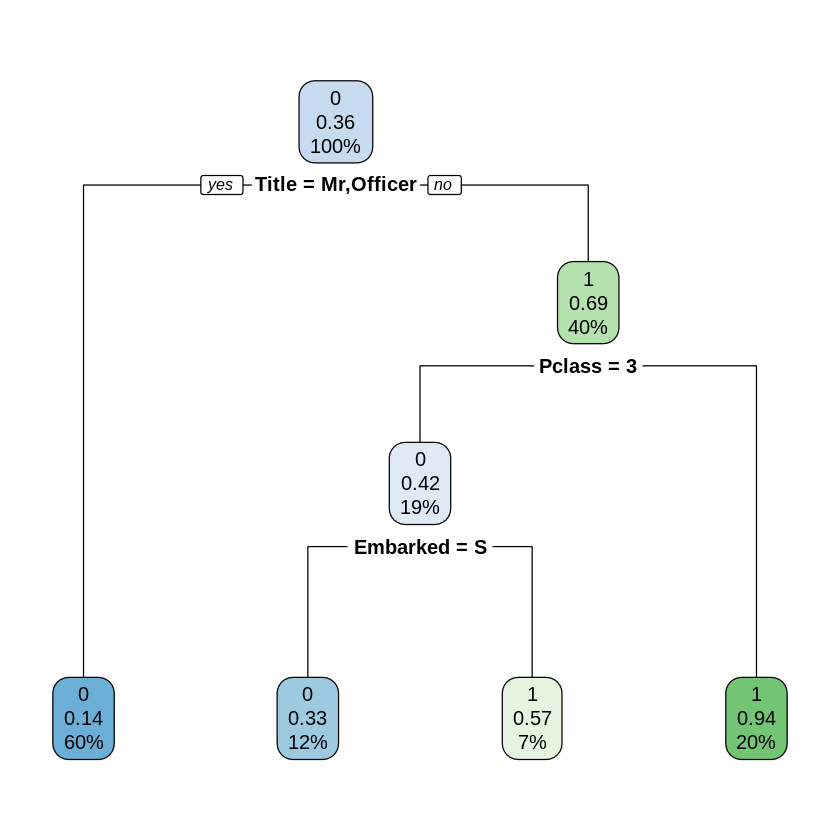

In [192]:
model_dt_2<- rpart(Survived ~Embarked+Pclass+Sex+Title,data=train1, method="class")
rpart.plot(model_dt_2)




In [193]:
pred.train.dt <- predict(model_dt_2,train2,type = "class")
mean(pred.train.dt==train2$Survived)

[1] 0.8107417

In [197]:
t2<-table(pred.train.dt,train2$Survived)

presicion_dt<- t2[1,1]/(sum(t2[1,]))
recall_dt<- t2[1,1]/(sum(t2[,1]))
presicion_dt
recall_dt
F1_dt<- 2*presicion_dt*recall_dt/(presicion_dt+recall_dt)
F1_dt

[1] 0.8063241

[1] 0.8947368

[1] 0.8482328

In [200]:
test_im[1:418,]

,Embarked,Pclass,Sex,Age,SibSp,Parch,Fare,Title
892,Q,3,male,34.50000,0,0,7.8292,Mr
893,S,3,female,47.00000,1,0,7.0000,Mrs
894,Q,2,male,62.00000,0,0,9.6875,Mr
895,S,3,male,27.00000,0,0,8.6625,Mr
896,S,3,female,22.00000,1,1,12.2875,Mrs
897,S,3,male,14.00000,0,0,9.2250,Mr
898,Q,3,female,30.00000,0,0,7.6292,Miss
899,S,2,male,26.00000,1,1,29.0000,Mr
900,C,3,female,18.00000,0,0,7.2292,Mrs
901,S,3,male,21.00000,2,0,24.1500,Mr


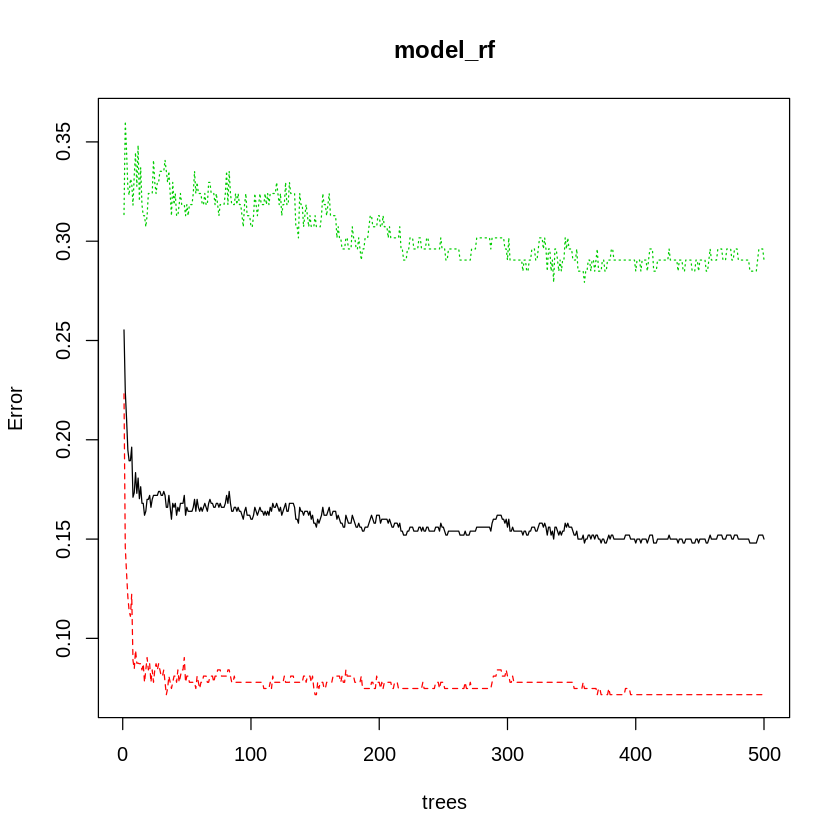

In [198]:
pred.test.dt <- predict(model_dt,test_im,type="class")[1:418]
res_dt<- data.frame(test$PassengerId,pred.test.dt)
names(res_dt)<-c("PassengerId","Survived")
write.csv(res_dt,file="res_dt.csv",row.names = F)

# Let's try to predict survival using a random forest.
model_rf<-randomForest(Survived~.,data=train1)
# Let's look at the error
plot(model_rf)

In [201]:
pred.train.rf <- predict(model_rf,train2)
mean(pred.train.rf==train2$Survived)

[1] 0.8081841

In [202]:
t1<-table(pred.train.rf,train2$Survived)
presicion<- t1[1,1]/(sum(t1[1,]))
recall<- t1[1,1]/(sum(t1[,1]))
presicion

[1] 0.7761733

In [203]:
F1<- 2*presicion*recall/(presicion+recall)
F1

[1] 0.8514851

In [205]:
# Let's run this model on the test set:
pred.test.rf <- predict(model_rf,test_set)[1:418]
res_rf<- data.frame(test$PassengerId,pred.test.rf)
names(res_rf)<-c("PassengerId","Survived")
write.csv(res_rf,file="res_rf.csv",row.names = F)